# Credit Card fraud from Kaggle is highly unbalanced

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

https://www.kaggle.com/mlg-ulb/creditcardfraud


### Goal: Is there fraud here?



# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import ray
from sklearn.preprocessing import *

In [3]:
from fastai import *
from fastai.tabular import *
from fastai.metrics import error_rate

In [4]:
from fastai.imports import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import *

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))
#Selecting the right GPU
torch.cuda.set_device(0)

pandas: 0.23.4
numpy: 1.15.4
Python: 3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


In [6]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

### Fuctions

In [7]:
#Nothing yet

# Load Data
Gets the data all put together

In [8]:
path= "/home/jd/data/creditcard/"
#df = pd.read_csv(path+'creditcard.csv')
#pickle.dump(df, open( path+'creditcard.p', "wb" ) )
df=pickle.load(open( path+'creditcard.p', "rb" ) )

In [9]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


# Data Preprocess
Any Required Preprocess

In [10]:
# Any missing data?
df.isnull().values.any()

False

In [11]:
# We want to see how uniques are out there matters.
# Notice how Time, Amount, and Class are less than the dataset
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
           ...  
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
Length: 31, dtype: int64

In [12]:
df.Amount.value_counts()

1.00       13688
1.98        6044
0.89        4872
9.99        4747
15.00       3280
0.76        2998
10.00       2950
1.29        2892
1.79        2623
0.99        2304
           ...  
133.19         1
254.07         1
108.66         1
308.82         1
154.59         1
192.63         1
218.84         1
195.52         1
793.50         1
1080.06        1
Name: Amount, Length: 32767, dtype: int64

In [13]:
df.Amount.max(), df.Amount.min()

(25691.16, 0.0)

In [14]:
df.Time.value_counts()

163152.0    36
64947.0     26
68780.0     25
3767.0      21
3770.0      20
128860.0    19
19912.0     19
3750.0      19
140347.0    19
143083.0    18
            ..
166848.0     1
80566.0      1
93598.0      1
93599.0      1
129204.0     1
2088.0       1
64100.0      1
42068.0      1
119630.0     1
140344.0     1
Name: Time, Length: 124592, dtype: int64

In [15]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# EDA
Items good to explore to see what occurs
https://www.kaggle.com/allunia/santander-customer-transaction-eda

## Seaborn Plots

In [17]:
import seaborn as sns
sns.set(style="ticks")

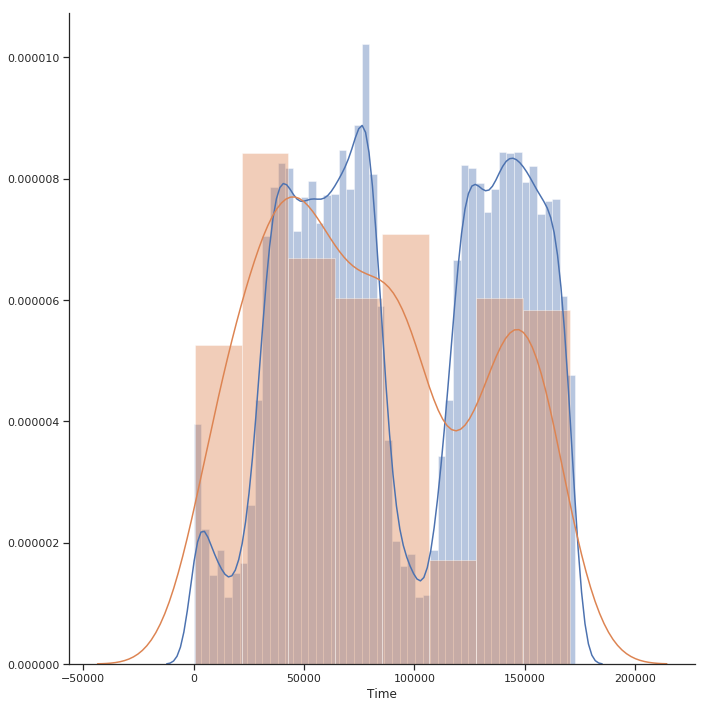

In [18]:
g= sns.set_style("ticks", {"xtick.major.width":.5,'xtick.minor.width': 0.25,
"ytick.major.size":1})
g = sns.FacetGrid(df, hue="Class",height=10 )
g = g.map(sns.distplot, "Time")

## Graph Plotting

In [19]:
df_fraud=df.loc[df['Class'] == 1]
df_nfraud=df.loc[df['Class'] == 0]

In [20]:
#How big of a problem is this?
sum(df_fraud['Amount'])/sum(df_nfraud['Amount'])

0.0023953017000574325

<Figure size 3600x2160 with 0 Axes>

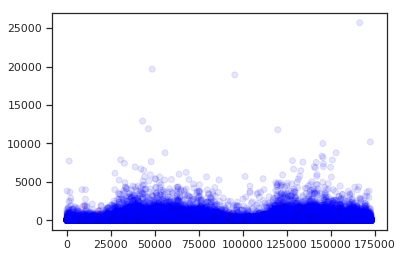

<Figure size 3600x2160 with 0 Axes>

In [21]:
fig, ax = plt.subplots()

colors = {1:'red', 0:'blue'}

ax.scatter(df['Time'], df['Amount'], c=df['Class'].apply(lambda x: colors[x]), alpha = .1)
plt.figure(figsize=(50,30))

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

cols = df_fraud.columns.tolist()

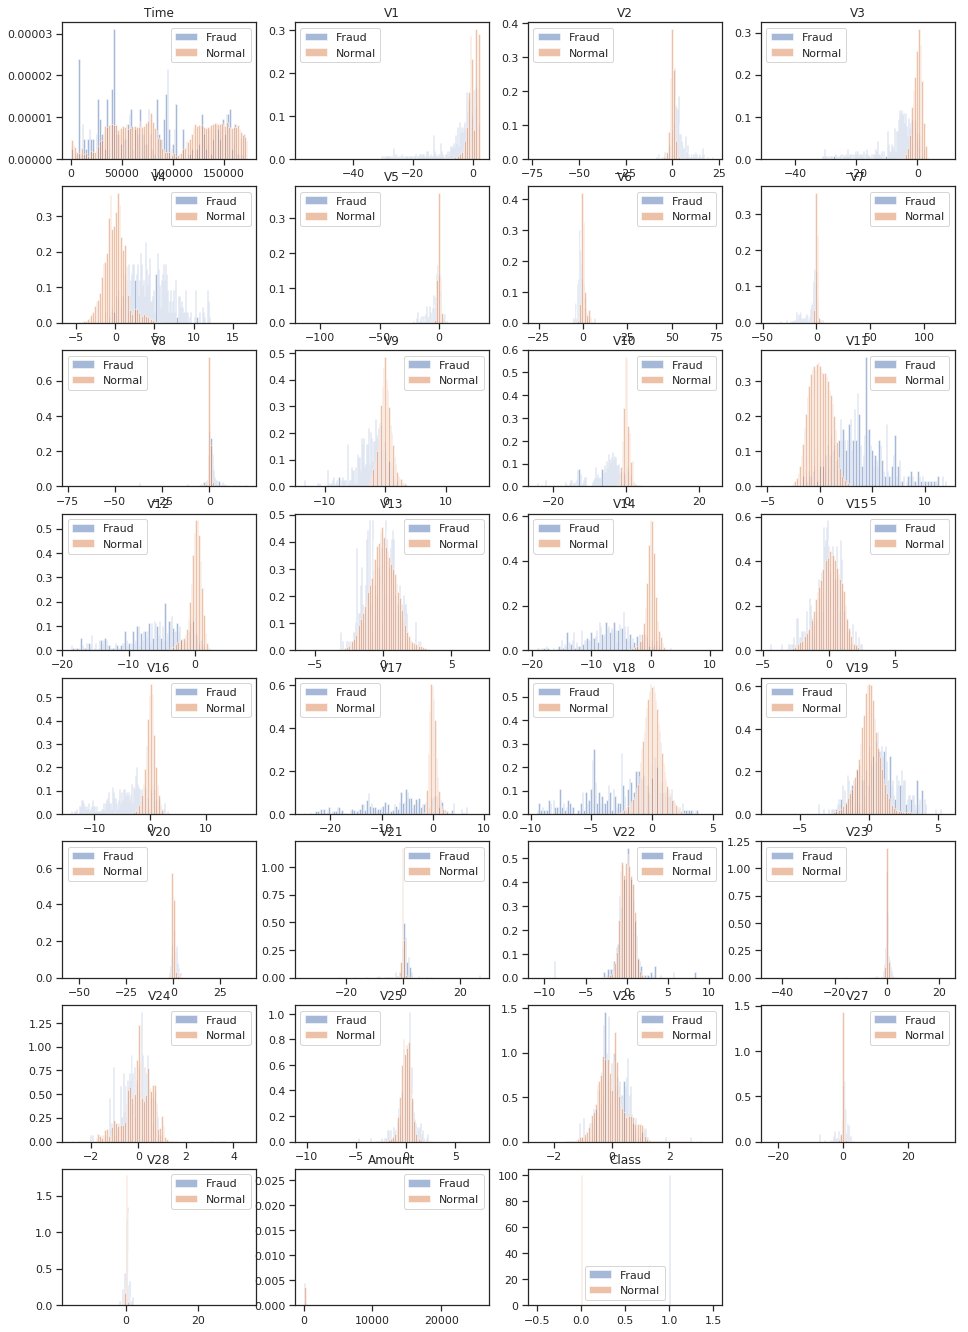

In [23]:
width_num = 4
height_num = 40
fig = plt.figure(figsize=[4*width_num,3*height_num])
for i in tqdm_notebook(range(len(cols))):
    ax = fig.add_subplot(height_num,width_num,i+1)
    _ = ax.hist(df_fraud[cols[i]], bins=100, alpha=0.5, density=True, label='Fraud')
    _ = ax.hist(df_nfraud[cols[i]], bins=100,alpha=0.5, density=True, label='Normal')
    _ = ax.set_title(cols[i])
    ax.legend()

# Validation Set Creation
Create the validation set to be used

#### Validation Set / Random 
Just run .split_by_rand_pct(valid_pct=0.1, seed=42)

#### Validation Set / Random - Stratified

In [24]:
# How many show fraud vs not
df_fraud=df.loc[df['Class'] == 1]
df_nfraud=df.loc[df['Class'] == 0]

In [25]:
#What percent do we want for test and validation
valid_percent= .2
test_percent= .2

In [26]:
df_ftrain, df_fvalid, df_ftest = np.split(df_fraud.sample(frac=1), [int((1-valid_percent-test_percent)*len(df_fraud)), int((1-test_percent)*len(df_fraud))])
df_ntrain, df_nvalid, df_ntest = np.split(df_nfraud.sample(frac=1), [int((1-valid_percent-test_percent)*len(df_nfraud)), int((1-test_percent)*len(df_nfraud))])

In [27]:
len(df_ntrain)+len(df_ftrain), len(df_nvalid)+len(df_fvalid)

(170884, 56961)

In [28]:
df_train= pd.concat([df_ntrain,df_ftrain]).sample(frac=1).reset_index(drop=True)
df_valid= pd.concat([df_nvalid,df_fvalid]).sample(frac=1).reset_index(drop=True)
df_test= pd.concat([df_ntest,df_ftest]).sample(frac=1).reset_index(drop=True)

In [29]:
df_train.Class.value_counts()

0    170589
1       295
Name: Class, dtype: int64

In [30]:
df_valid.Class.value_counts()

0    56863
1       98
Name: Class, dtype: int64

#### Oversampling
Get oversampling for train

In [31]:
# Adds in some more fraud values
for i in range(1,40):
    df_train= pd.concat([df_train,df_ftrain,df_ftrain]).sample(frac=1).reset_index(drop=True)

In [32]:
df_train.Class.value_counts()

0    170589
1     23305
Name: Class, dtype: int64

In [33]:
df_valid

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,36133.0,1.281210,-1.152515,-0.019039,-1.394655,-1.151084,-0.611591,-0.559136,-0.112942,-2.424942,...,-0.365323,-0.924197,0.124201,0.171056,0.168267,-0.458243,-0.002141,0.018252,99.37,0
1,73265.0,-3.677286,3.208451,-1.089825,-0.098935,-2.373251,-1.124581,-1.662205,2.756257,-0.518645,...,-0.075494,-0.743472,0.343300,0.458434,0.094122,0.080354,0.032096,0.023978,9.82,0
2,141717.0,-0.519748,1.156497,2.332964,2.393606,0.764035,0.436828,0.764227,-0.070326,-1.133820,...,0.257673,0.963283,-0.343594,-0.098732,-0.103978,-0.047213,-0.024539,-0.062772,5.95,0
3,153781.0,-0.457156,-0.371715,1.993044,-2.335770,-0.512347,0.985996,-0.626904,0.367007,0.415201,...,0.142807,0.737815,-0.232599,0.285515,-0.325000,-0.350965,0.116120,-0.016349,2.00,0
4,56269.0,0.318851,1.826951,-2.085437,1.616747,0.847814,-1.232647,0.502193,0.370033,-0.913580,...,0.007801,0.146148,0.200622,-0.103364,-0.535366,-0.402447,0.146220,-0.062592,15.25,0
5,27240.0,1.100194,-0.073117,-0.411282,0.473965,0.287575,-0.184361,0.387912,-0.165050,-0.117307,...,-0.018556,-0.196407,-0.229285,-0.715470,0.582926,0.437122,-0.053540,0.012766,107.60,0
6,87707.0,2.124482,-0.022647,-1.525461,0.120195,0.554878,-0.344493,0.167365,-0.237110,0.457064,...,-0.334549,-0.827964,0.272990,0.052948,-0.152323,0.205393,-0.071534,-0.058609,2.58,0
7,42204.0,-0.436689,1.031423,1.457253,-0.229733,0.191903,-0.358692,0.662751,0.059261,-0.742546,...,-0.187282,-0.484282,-0.073439,0.002928,-0.154730,0.071539,0.264262,0.109269,7.44,0
8,136264.0,-3.221994,-0.813384,1.046717,-0.377983,-1.605824,1.767083,-0.865389,1.509364,1.711297,...,-0.067954,0.148694,-0.971805,-1.269283,0.614912,0.947888,0.540417,-0.265800,229.31,0
9,155855.0,-0.857631,1.255798,-2.960679,-0.650736,1.836649,0.505666,0.628661,0.753718,-0.702098,...,0.760160,2.150912,0.249447,-0.659789,-1.288945,-0.126832,-0.416736,0.228559,3.55,0


### Save the data

In [34]:
len(df_train)+len(df_valid)

250855

In [35]:
df_fixed= pd.concat([df_train,df_valid])

In [36]:
valid_idx= range(len(df_train),len(df_train)+len(df_valid))

In [37]:
pickle.dump(df_fixed, open( path+'df_fixed.p', "wb" ) )
pickle.dump(valid_idx, open( path+'valid_idx.p', "wb" ) )
pickle.dump(df_test, open( path+'df_test.p', "wb" ) )


# Training

In [38]:
# Load the databack
df_fixed=pickle.load(open( path+'df_fixed.p', "rb" ) )
valid_idx=pickle.load(open( path+'valid_idx.p', "rb" ) )
df_test=pickle.load(open( path+'df_test.p', "rb" ) )


cont_names= list(df.columns)
cont_names.remove('Class')
cont_names.remove('Amount')
cont_names.remove('Time')
cat_names = list(['Time','Amount'])

## Loss Function

In [39]:
#Auroc
from sklearn.metrics import roc_auc_score

def auc_score1(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))

## Testset

In [40]:
df_test.Class.value_counts()

0    56863
1       99
Name: Class, dtype: int64

In [41]:
df_test = df_test.reset_index(drop=False)

In [42]:
df_test_answers=df_test[['index','Class']]

In [43]:
df_test_answers.Class.value_counts()

0    56863
1       99
Name: Class, dtype: int64

In [44]:
df_test.pop('Class')

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
        ..
56952    0
56953    0
56954    0
56955    0
56956    0
56957    0
56958    0
56959    0
56960    0
56961    0
Name: Class, Length: 56962, dtype: int64

## Data and Learner building

In [45]:
dep_var = "Class"
procs = [FillMissing, Categorify, Normalize]

In [46]:
# Test data is stored here.
test = TabularList.from_df(df_test, path=path, cat_names=cat_names, cont_names=cont_names)

In [47]:
#valid_idx=valid_idx.tolist
valid_idx

range(193894, 250855)

In [48]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           #.split_by_rand_pct(valid_pct=0.1, seed=42)
                           .split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var, label_cls=CategoryList)
                           .add_test(test)
                           .databunch(bs=9000))

In [49]:
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.2,0.04],
                        emb_drop=0.06, 
                        y_range=None,
                        metrics=[accuracy, auc_score1]
                        #, callback_fns=AUROC
                        #,callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)]
                        )

In [50]:
#learn.loss_func = exp_rmspe

In [51]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [600]                61,478,400 True      
______________________________________________________________________
Embedding            [505]                14,665,200 True      
______________________________________________________________________
Dropout              [1105]               0          False     
______________________________________________________________________
BatchNorm1d          [28]                 56         True      
______________________________________________________________________
Linear               [1000]               1,134,000  True      
______________________________________________________________________
ReLU                 [1000]               0          False     
______________________________________________________________________
BatchNorm1d          [1000]               2,000      True      
______________________________________________________________

## Start Learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


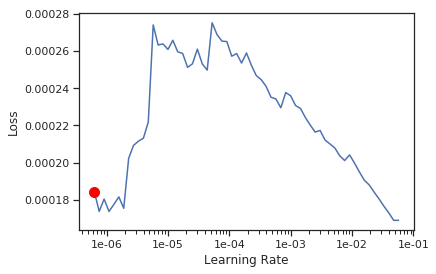

In [66]:
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

# See plot
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [53]:
learn.fit_one_cycle(10,1.5e-02, wd=0.1)

epoch,train_loss,valid_loss,accuracy,auc_score1,time
0,0.512918,0.264797,0.998385,0.841773,00:03
1,0.222670,0.020473,0.998859,0.610461,00:03
2,0.116390,0.004531,0.999579,0.962086,00:03
3,0.064619,0.003189,0.999596,0.941558,00:03
4,0.037438,0.002938,0.999561,0.959410,00:03
5,0.022022,0.002805,0.999561,0.958001,00:03
6,0.013120,0.002780,0.999561,0.964926,00:03
7,0.007892,0.002739,0.999561,0.968884,00:03
8,0.004809,0.002709,0.999579,0.969843,00:03
9,0.002949,0.002732,0.999561,0.970016,00:03


In [54]:
learn.fit_one_cycle(10,1.5e-02, wd=0.1)

epoch,train_loss,valid_loss,accuracy,auc_score1,time
0,0.000141,0.002787,0.999561,0.970212,00:03
1,0.000143,0.002818,0.999561,0.968846,00:03
2,0.000195,0.002997,0.999508,0.961683,00:03
3,0.000461,0.003460,0.999473,0.926969,00:03
4,0.001010,0.002879,0.999561,0.939304,00:03
5,0.000960,0.002867,0.999579,0.955734,00:03
6,0.000690,0.003274,0.999491,0.935810,00:03
7,0.000469,0.003203,0.999491,0.939317,00:03
8,0.000307,0.003124,0.999508,0.942747,00:03
9,0.000207,0.003144,0.999508,0.944187,00:03


In [74]:
learn.fit_one_cycle(10,1.5e-02, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auc_score1', name='best')], wd=0.1)

epoch,train_loss,valid_loss,accuracy,auc_score1,time
0,0.000229,0.003365,0.999561,0.974775,00:03
1,0.000148,0.003321,0.999544,0.974600,00:03
2,0.000143,0.004696,0.999368,0.939467,00:03
3,0.000325,0.003376,0.999596,0.958916,00:03
4,0.000366,0.003265,0.999491,0.975629,00:03
5,0.000386,0.003236,0.999579,0.984899,00:03
6,0.000282,0.003396,0.999579,0.988285,00:03
7,0.000185,0.003355,0.999596,0.986126,00:03
8,0.000127,0.003463,0.999579,0.987167,00:03
9,0.000082,0.003531,0.999561,0.986660,00:03


Better model found at epoch 0 with auc_score1 value: 0.9747752547264099.
Better model found at epoch 4 with auc_score1 value: 0.9756289720535278.
Better model found at epoch 5 with auc_score1 value: 0.9848987460136414.
Better model found at epoch 6 with auc_score1 value: 0.9882850646972656.


In [78]:
#learn.load('best')

# Evaluate

In [76]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

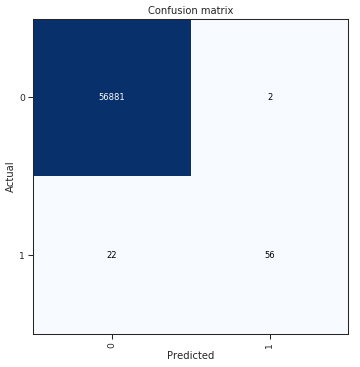

In [77]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

# Run Test

In [60]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [61]:
preds[0][:,1]

tensor([4.3887e-05, 1.0917e-05, 3.6078e-05,  ..., 1.4508e-05, 2.8198e-05,
        1.2842e-05])

In [62]:
df_test_answers['predictions']= preds[0][:,1]

/home/jd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
df_test_answers[:5]

,index,Class,predictions
0,0,0,0.000044
1,1,0,0.000011
2,2,0,0.000036
3,3,0,0.000039
4,4,0,0.000016


In [64]:
roc_auc_score(df_test_answers['Class'],df_test_answers['predictions'])

0.9998665941194476

In [69]:
abs(0-1)

1

In [68]:
1-.00002

0.99998

In [71]:
df_test_answers['Diff']= abs(df_test_answers['Class']-df_test_answers['predictions'])

/home/jd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
df_test_answers.sort_values(by='Diff', ascending=False)

,index,Class,predictions,Diff
36548,36548,1,0.000155,0.999845
49030,49030,1,0.004804,0.995196
25112,25112,1,0.036184,0.963816
19579,19579,0,0.906501,0.906501
37782,37782,1,0.157758,0.842242
26553,26553,0,0.415694,0.415694
54249,54249,0,0.350762,0.350762
11879,11879,1,0.671205,0.328795
41909,41909,1,0.720238,0.279762
43792,43792,1,0.732050,0.267950
